# Cleanup and normalization

### Install and import packages

In [1]:
! pip install pandas matplotlib numpy scipy
import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import zip_longest

### Load data
Pickle created in `import.ipynb`

In [2]:
df = pd.read_pickle('data/imported.pickle')

Set timezone

In [3]:
# Localize index
_ = df.tz_convert('Europe/Paris', copy=False)

## Sampling rate

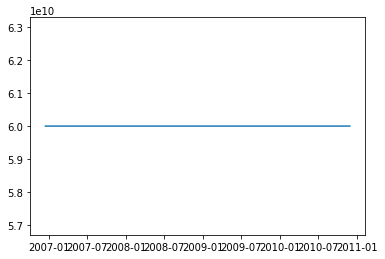

In [4]:
deltas = df.index.to_series().diff(1)

# Shift out one row since pandas gives NaT for the first entry
# as there was no previous item to diff against
deltas = deltas[1:]

# Plot the series
plt.plot(deltas)

How many samples are invalid? (ie NaT :: Not a Time)

In [5]:
len(deltas[deltas.isna()])

0

What is the date range of the dataset?

In [6]:
[df.index.min(), df.index.max()]

[Timestamp('2006-12-16 18:24:00+0100', tz='Europe/Paris'),
 Timestamp('2010-11-26 22:02:00+0100', tz='Europe/Paris')]

How many unique time differences are there?

In [7]:
uniq_tdiff = deltas.unique()
len(uniq_tdiff)

1

In [8]:
# And to be sure the unique delta is one minute
np.timedelta64(1, 'm') == uniq_tdiff[0]

True

So there are no missing timestamps between Dec. 16 2006 and Nov. 26 2010 we have a resolution of one minute intervals. Samples could be stochastic within the minute, but there is no visible evidence of any deviation on the highest available resolution.

## Missing data

In [9]:
missing = {
    'all': df.isnull().all(axis=1),
    'some': df.isnull().any(axis=1)
}

print(
    '{} samples are missing all values, and {} samples are missing some values'
    .format(
        missing['all'].sum(),
        missing['some'].sum() - missing['all'].sum()
))

25979 samples are missing all values, and 0 samples are missing some values


Do the missing samples occur in groups?

In [10]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def sequential_nans(frame):
    "Returns an iterator over start and end times for sequential NaN groups"
    nandiff = frame.isnull().any(axis=1) + frame.isnull().any(axis=1).shift(1)
    return grouper(frame[nandiff == 1].index, 2)

Count of blocks of sequential missing values


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
block length,1,2,3,4,6,21,24,33,38,43,47,70,83,891,2027,3129,3305,3723,5237,7226
occurances,38,14,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


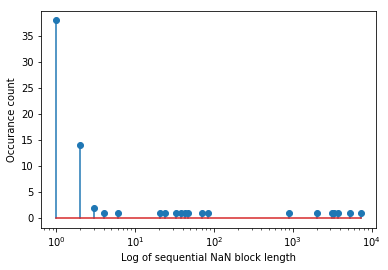

In [11]:
duration_rows = [df.index.get_loc(end) - df.index.get_loc(start) for [start, end] in sequential_nans(df)]
unique, counts = np.unique(duration_rows, return_counts=True)

print('Count of blocks of sequential missing values')
plt.stem(unique, counts)
plt.xscale('log')
plt.ylabel('Occurance count')
plt.xlabel('Log of sequential NaN block length')
pd.DataFrame.from_dict({'block length': unique, 'occurances': counts}, orient='index')

### Interpolate small gaps

In [12]:
# df.interpolate fills all gaps with up to `limit` interpolated values.
# I want to only touch gaps less than `limit`, so we'll work with interpolate 
# on smaller dataframes.

for [start, end] in sequential_nans(df):
    if (end-start) < pd.Timedelta('10m'):
        scale = 4 * (end - start)
        idf = df[(start-scale):(end+scale)].interpolate(method='linear', limit=10)
        
        df[(start):(end)] = idf[(start):(end)]

In [13]:
# How many samples are missing now?
df.isnull().any(axis=1).sum()

25897

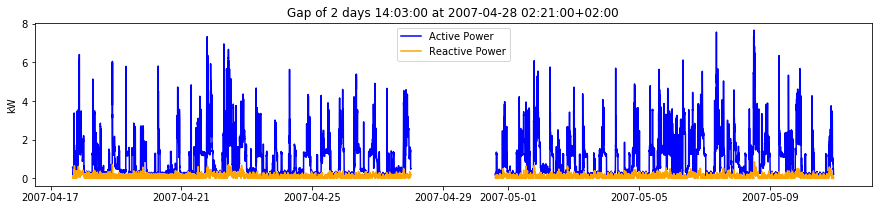

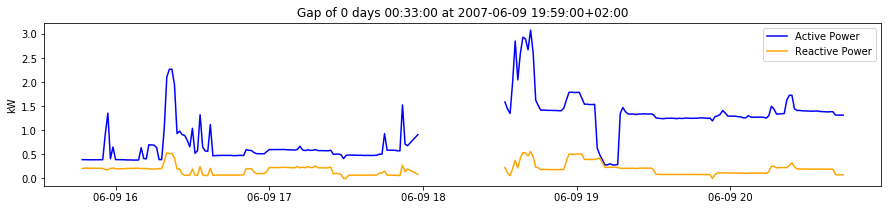

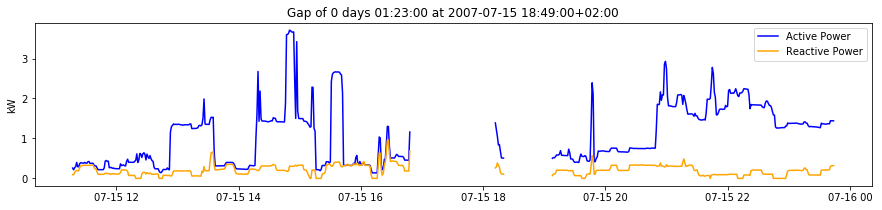

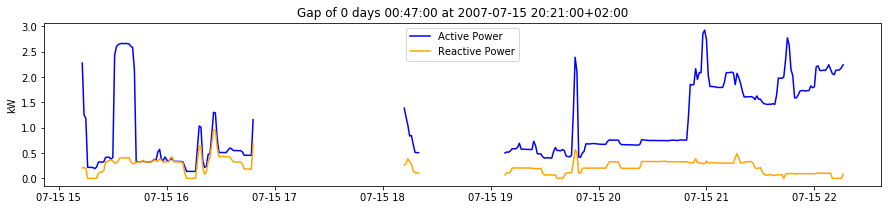

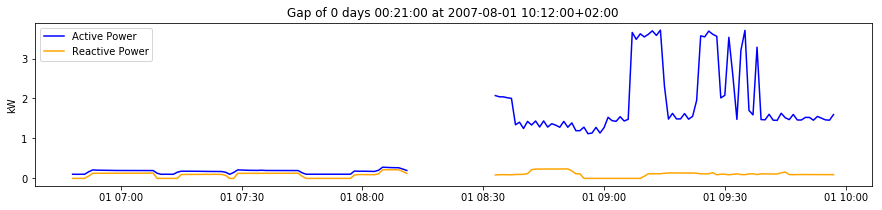

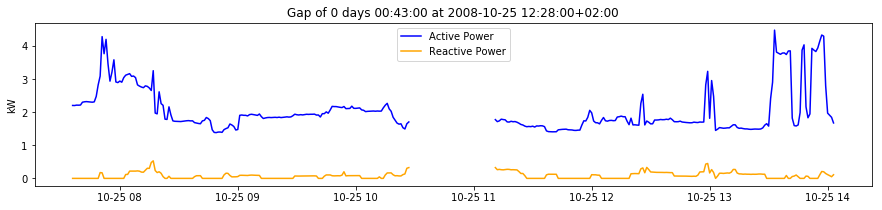

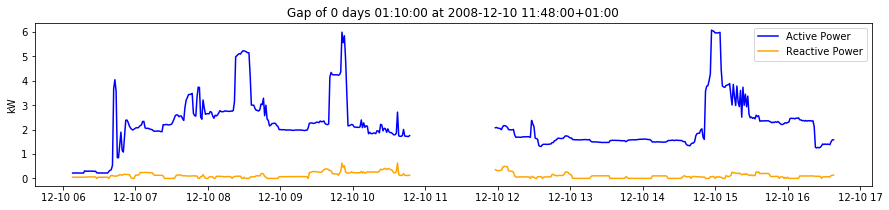

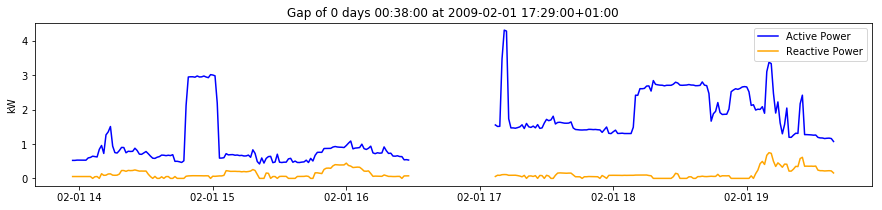

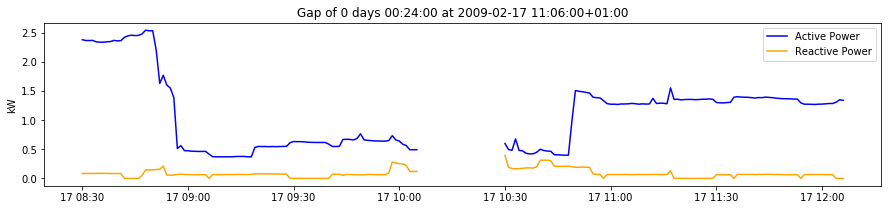

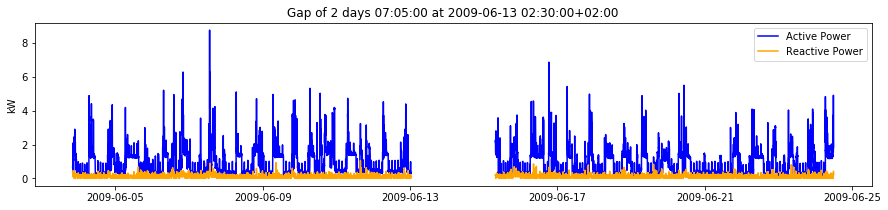

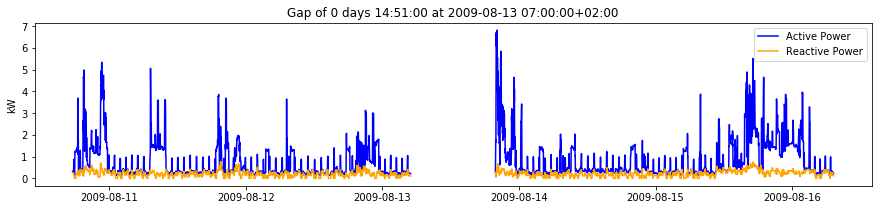

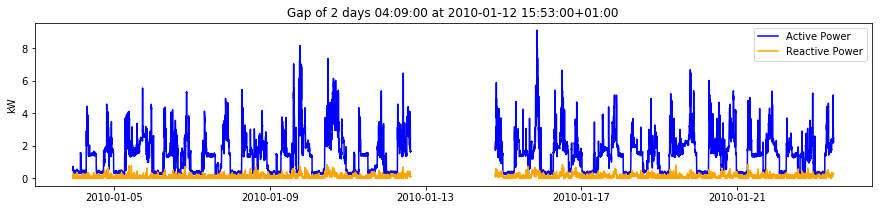

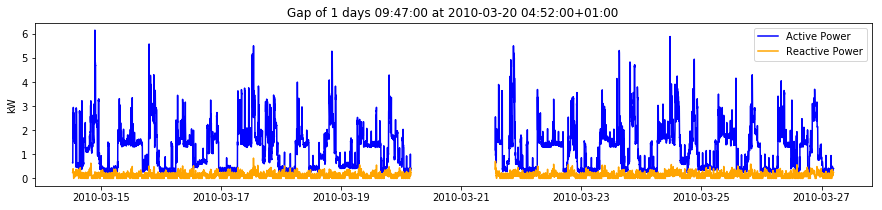

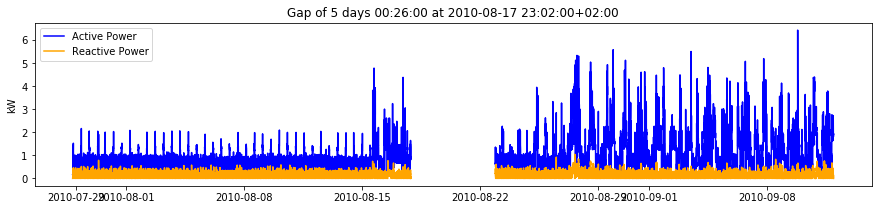

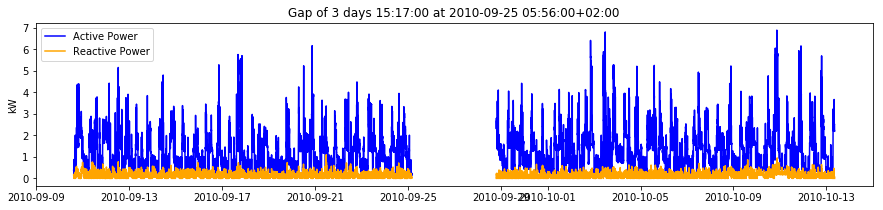

In [14]:
# What do the remaining discontinuities look like?
for [start, end] in sequential_nans(df):
    plt.figure(figsize=(15,3))
    scale = 4 * (end - start)
    indx = df[(start-scale):(end+scale)]
    hActive = plt.plot(indx.active, color='blue', label='Active Power')
    hReactive = plt.plot(indx.reactive, color='orange', label='Reactive Power')
    plt.title('Gap of {} at {}'.format(end - start, start))
    plt.ylabel('kW')
    plt.legend()

For these remaining discontinuities we don't have a viable interpolation method, so we'll drop the invalid rows from the dataframe. Note: this **doesn't** change anything in the data - it is indexed by time, so the gaps are still going to discernable

In [15]:
df = df[df.isnull().any(axis=1) == False]
df.head()

,active,reactive,volts,amps,sub1,sub2,sub3
dtime,,,,,,,
2006-12-16 18:24:00+01:00,4.216,0.418,234.84,18.4,0.0,0.06,0.0036
2006-12-16 18:25:00+01:00,5.360,0.436,233.63,23.0,0.0,0.06,0.0036
2006-12-16 18:26:00+01:00,5.374,0.498,233.29,23.0,0.0,0.12,0.0072
2006-12-16 18:27:00+01:00,5.388,0.502,233.74,23.0,0.0,0.06,0.0036
2006-12-16 18:28:00+01:00,3.666,0.528,235.68,15.8,0.0,0.06,0.0036


## Artifical Columns

In [16]:
# Create artificial 'house' column 
df['house'] = df.active - df[['sub1','sub2','sub3']].sum(axis=1)

## Normalization

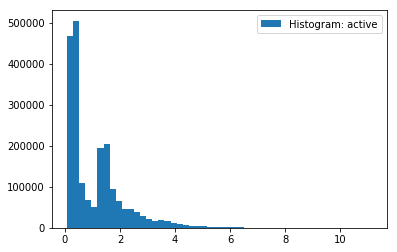

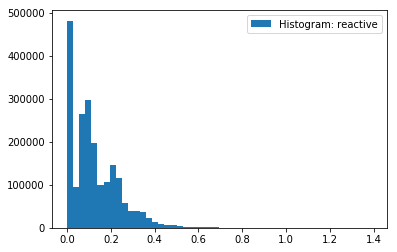

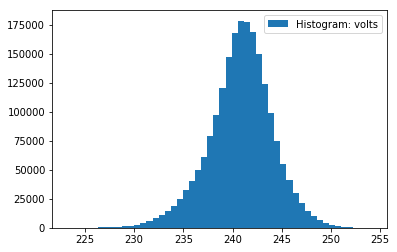

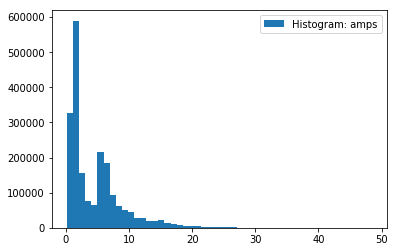

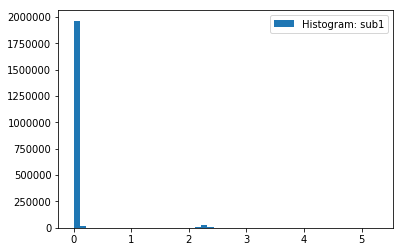

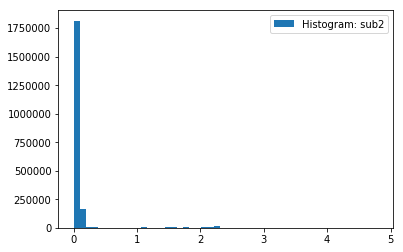

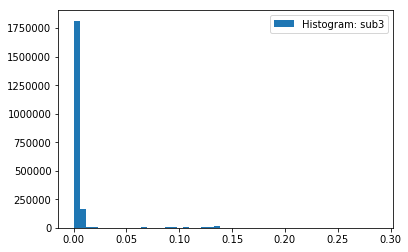

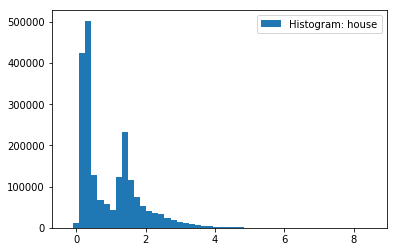

In [17]:
# Show histograms of each feature before normalizing
for col in df:
    plt.hist(df[col], bins=50, label='Histogram: {}'.format(col))
    plt.legend()
    plt.show()

Inspecting the source file, the regex `\.\d{3};` matches ***many*** times, but `\.\d{2};` and `\.\d{4};` never match. We've introduced some floating point errors during cleaning, so we'll round all columns back to 3 decimal digits, we'll lose the rounding during normalization below, so we introduce a new dataframe.

In [18]:
decimals = {
    'active':   3,
    'reactive': 3,
    'volts':    3,
    'amps':     3,
    'sub1':     3,
    'sub2':     3,
    'sub3':     3,
    'house':    3
}

df = df.round(decimals)

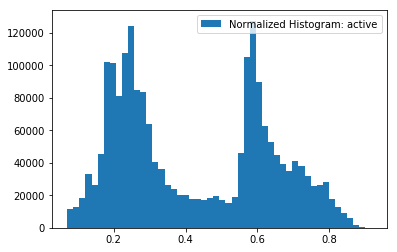

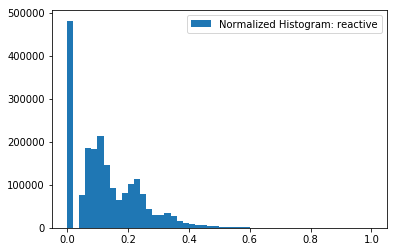

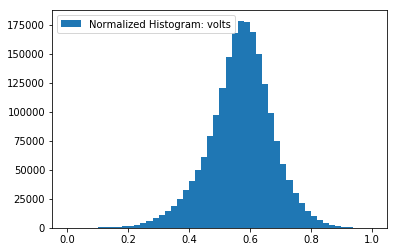

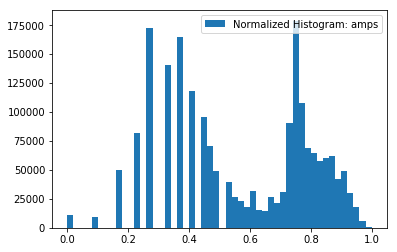

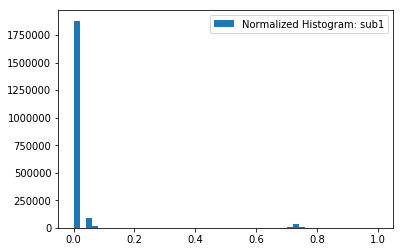

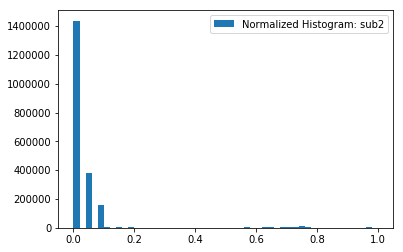

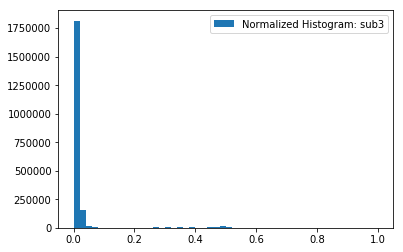

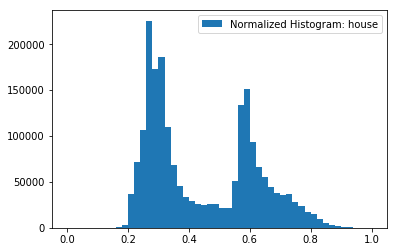

In [19]:
from functools import reduce
compose = lambda *funcs: lambda x: reduce(lambda acc, f: f(acc), funcs, x)

scaleTo = lambda a,b: lambda series: a + (b - a) * (series - series.min()) / (series.max() - series.min())
sigmoid = lambda series: 1 / (1 + np.exp(-series))

normalization_methods = {
    'active':   compose(np.log, sigmoid),
    'reactive': compose(np.log1p, scaleTo(0, 1)),
    'volts':    scaleTo(0, 1),
    'amps':     compose(np.log1p, sigmoid, scaleTo(0, 1)),
    'sub1':     compose(np.log1p, sigmoid, scaleTo(0, 1)),
    'sub2':     compose(np.log1p, sigmoid, scaleTo(0, 1)),
    'sub3':     compose(np.log1p, sigmoid, scaleTo(0, 1)),
    'house':    compose(np.log1p, sigmoid, scaleTo(0, 1))
}

# Create a new dataframe and apply the normalizations
nf = pd.DataFrame(index=df.index)
for col in df:
    nf[col] = normalization_methods[col](df[col])

# Now show histograms of the normalized features
for col in nf:
    plt.hist(nf[col], bins=50, label='Normalized Histogram: {}'.format(col))
    plt.legend()
    plt.show()

## Export

In [20]:
df.to_pickle('data/cleaned.pickle')
nf.to_pickle('data/normalized.pickle')

Also export to matfiles to support laglag plots in MATLAB

In [21]:
sio.savemat('data/cleaned-hourly.mat',    {'data': df.resample('H').mean().to_dict('list')})
sio.savemat('data/normalized-hourly.mat', {'data': nf.resample('H').mean().to_dict('list')})